## Imports

In [1]:
import sys
import os 
import warnings
import numpy as np
import matplotlib.pyplot as plt

pkg_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pkg_path)

np.set_printoptions(threshold=np.inf, suppress=True, linewidth=np.inf)
warnings.filterwarnings(action='ignore', category=UserWarning)

import shtmbss2.addsrc
from shtmbss2.common.config import *
from shtmbss2.core.logging import log

Could not load module 'colorlog'. Continuing logging without colored formatter.


In [2]:
RuntimeConfig.backend = Backends.BRAIN_SCALES_2
RuntimeConfig.plasticity_location = PlasticityLocation.ON_CHIP

In [3]:
shtm = None
offset = 0
if RuntimeConfig.backend == Backends.BRAIN_SCALES_2:
    from pynn_brainscales import brainscales2 as pynn
    from shtmbss2.brainscales2.hardware import hardware_initialization
    from shtmbss2.brainscales2.network import SHTMTotal
elif RuntimeConfig.backend == Backends.NEST:
    from shtmbss2.nest.network import SHTMTotal
    
from shtmbss2.common.network import NeuronType, RecTypes

## Configuration

In [5]:
num_runs = 1
debug = False

# membrane noise
num_runs = 10

# con_ids = []

con_ids = [2, 9, 14]
dend_ids = [5, 10]

# con_ids = [1, 6, 11]  # 4x4
# dend_ids = [0, 5, 10]     # 4 


new_weight = 35
p_con = 1.0

## Network Initialization

In [6]:
shtm = SHTMTotal(use_on_chip_plasticity=RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP)
shtm.init_backend(offset=0)

# FIXME: the timer only starts at start_time + period, fake calculation
# to get exactly one execution at the end of each runtime
if RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP:
    shtm.init_plasticity_rule()
    
finished_preprocessing = False
while not finished_preprocessing:
    try:
        shtm.init_neurons()
    except HardwareError as e:
        log.error("Experienced Hardware error. Trying again.")
    else:
        finished_preprocessing = True
shtm.init_connections(debug=debug)
shtm.init_external_input()

if RuntimeConfig.backend == Backends.BRAIN_SCALES_2:
    shtm.init_rec_exc()
    
shtm.init_prerun()


Initialized backend


INFO  12:42:25,246  demo_helpers Using setup hxcube7fpga0chip57_1


Starting preprocessing/calibration...
Finished prerun


In [7]:
# Set weights of exc-exc connections for 
post_ids = range(shtm.p.network.num_neurons)

weights = shtm.exc_to_exc[0].get("weight", format="array")
weights = np.zeros((60, 60))

for con_id in con_ids:
    y_start = con_id%shtm.p.network.num_symbols * shtm.p.network.num_neurons
    y_end = y_start + shtm.p.network.num_neurons
    x_start = int(con_id/shtm.p.network.num_symbols) * shtm.p.network.num_neurons
    x_end = x_start + shtm.p.network.num_neurons
    
    weights_i = weights[x_start:x_end, y_start:y_end]
    
    for i in post_ids:
        pre_ids = np.logical_not(np.isnan(weights_i[:, i]))
        pre_ids = pre_ids[:int(p_con * len(pre_ids))]
        weights_i[pre_ids, i] = new_weight
        
    weights[x_start:x_end, y_start:y_end] = weights_i
    
shtm.exc_to_exc[0].set(weight=weights)

## Network Emulation

In [8]:
shtm.run(steps=1, plasticity_enabled=RuntimeConfig.plasticity_location==PlasticityLocation.OFF_CHIP)

Running emulation step 1/1
Computing performance for 2 Sequences.
Performance (0.5):  0.0  |  Epochs:  -1


## Data calculation

In [10]:
# Retrieve data for spike time distribution
t_max = shtm.calc_runtime_single() * num_runs

spike_times_normalized = list()
for i_symbol in [0, 3]:
    for ext_spike in shtm.spike_times_ext[i_symbol]:
        for i_neuron in range(shtm.p.network.num_neurons):
            spikes_i = shtm.neuron_events[NeuronType.Soma][i_symbol][i_neuron]
            for spike_i in spikes_i:
                if ext_spike < spike_i < ext_spike + shtm.p.encoding.dt_stm:
                    spike_times_normalized.append(float(spike_i) - ext_spike)
                elif spike_i > ext_spike + shtm.p.encoding.dt_stm:
                    break
spike_times_normalized = np.array(spike_times_normalized) / shtm.p.encoding.t_scaling_factor
print(np.mean(spike_times_normalized), np.std(spike_times_normalized))
        


2.4444191294846775 0.5169522769836636


In [11]:
# Retrieve data for soma-soma connections

# num_cor_events_soma_total = list()
cor_soma_total = list()
for con_id in con_ids:
    cor_soma_i, _ = shtm.get_neuron_data_from_matrix(shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("correlation")[-1].data, con_id)
    cor_soma_total += cor_soma_i.flatten().tolist()
    
    # num_cor_events_soma = calc_num_cor_events(NeuronType.Soma, NeuronType.Soma, symbol_id=con_id,
    #                                      t_max=shtm.p.encoding.dt_stm*1.5)
    # num_cor_events_soma_total += num_cor_events_soma

In [12]:
# Retrieve data for dendrite-soma connections

num_cor_events_dend_total = list()
cor_dend_total = list()
cor_dend_all = list()
for dendrite_id in dend_ids:
    symbol_id = int(dendrite_id / 5)
    cor_dend_i, _ = shtm.get_neuron_data_from_matrix(shtm.exc_to_exc_dendrite_to_soma_dummy[0].get_data("correlation")[-1].data, dendrite_id)
    cor_dend_i_ = cor_dend_i[0][cor_dend_i[0] >= 0]
    cor_dend_total += cor_dend_i_.tolist()
    cor_dend_all.append(cor_dend_i_.tolist())
    
    num_cor_events_dend = shtm.calc_num_cor_events(NeuronType.Dendrite, NeuronType.Soma, symbol_id=symbol_id,
                                         t_max=shtm.p.neurons.excitatory.tau_refrac[0])
    num_cor_events_dend_total += num_cor_events_dend.tolist()


## Additional analysis of dend-soma correlations

In [21]:
a, b = get_neuron_data_from_all(shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("correlation")[-1].data, 
                                dendrite_id)

np.diagonal(a)
# a

array([ 81,  21,  71, 118,  72,  25, 112,  26, 103,  67,  42,  49,  28,  30,  32])

In [15]:
cor_dend_i[0]

array([ 78,  30,  62, 108,  76,  33,  84,  32, 103,  63,  40,  47,  35,  32,  35])

In [14]:
num_cor_events_dend

array([118., 104., 106., 104., 107., 106., 113., 110., 105., 105., 106., 112., 106., 104., 104.])

In [34]:
# manually gathered data for dend-coma correlations of 'C'
# times: 40, 60, 80, 100 ms

org_long = np.array([ 78,  28,  63, 127,  66,  26,  85,  26, 127,  49,  22,  51,  34,  41,  46])

res_very_long = np.array([  68,  123,   73,   80,   33,   47, 127, 127,  112,   49,   41,   48,   88,   44,   98])
res_long = np.array([  50,   95,   77,   90,   24,   25,   47, 127,   78,   39,   53,   44,   50,   34,   37])
res_mid = np.array([  50,   77,   57,   70,   26,   31,   49, 127,   50,   48,   35,   58,   67,   31,   56])
res_short = np.array([33, 48, 38, 63, 16, 21, 38, 36, 51, 32, 29, 20, 30, 25, 33])
res_none = np.array([39, 41, 45, 47, 34, 26, 43, 42, 48, 43, 30, 41, 46, 44, 29])

res_all = [res_short, res_mid, res_long, res_very_long]
res_all = np.array(res_all)

cor_events_very_long = np.array([128., 125., 124., 118., 136., 129., 124., 125., 112., 140., 134., 115., 127., 134., 123.])
cor_events_long = np.array([107., 115., 113., 111., 116., 120., 119., 120., 109., 115., 115., 110., 117., 115., 118.])
cor_events_mid = np.array([94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94.])
cor_events_short = np.array([63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63.])

cor_events_all = [cor_events_short, cor_events_mid, cor_events_long, cor_events_very_long]
cor_events_all = np.array(cor_events_all)

# res_total = res_all / cor_events_all
res_total = res_all

print(res_total)

res_total = res_total[1:] / res_total[:-1]
res_total = np.round(res_total, 2)

print(res_total)





[[ 33  48  38  63  16  21  38  36  51  32  29  20  30  25  33]
 [ 50  77  57  70  26  31  49 127  50  48  35  58  67  31  56]
 [ 50  95  77  90  24  25  47 127  78  39  53  44  50  34  37]
 [ 68 123  73  80  33  47 127 127 112  49  41  48  88  44  98]]
[[1.52 1.6  1.5  1.11 1.62 1.48 1.29 3.53 0.98 1.5  1.21 2.9  2.23 1.24 1.7 ]
 [1.   1.23 1.35 1.29 0.92 0.81 0.96 1.   1.56 0.81 1.51 0.76 0.75 1.1  0.66]
 [1.36 1.29 0.95 0.89 1.38 1.88 2.7  1.   1.44 1.26 0.77 1.09 1.76 1.29 2.65]]


In [ ]:
# Plot number of spikes throughout one learning cycle - investigation of reliability/repeatability of setup

%matplotlib inline
import matplotlib.pyplot as plt

num_events = np.zeros(60)

neuron_id = 0
for symbol_events in shtm.neuron_events[NeuronType.Soma]:
    for neuron_events in symbol_events:
        # print(neuron_events)
        num_events[neuron_id] = np.sum(len(neuron_events))
        neuron_id += 1

plt.plot(num_events)

In [ ]:
# Plot all correlation values from one neuron/synapse

%matplotlib inline
import matplotlib.pyplot as plt

# con_id = 0    # A
# con_id = 2    # A -> C
# con_id = 5    # B
con_id = 1   # C
# con_id = 9      # C -> B
# con_id = 13      # D -> B
# con_id = 14      # D -> C

# soma-soma
cor_data = shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("correlation")[-1].data
# dendrite-soma
# cor_data = shtm.exc_to_exc_dendrite_to_soma_dummy[0].get_data("correlation")[-1].data
# permanence
# cor_data = shtm.exc_to_exc_dendrite_to_soma_dummy[0].get_data("data")[-1].data
# num pre-soma spikes
# cor_data = shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("data")[-1].data

print(f"max[:]: {np.max(cor)}")
print(f"min[:]: {np.min(cor)}")

data_arr = shtm.get_neuron_data_from_matrix(cor_data, con_id)

print(f"max[{con_id}]: {np.max(data_arr)}")
print(f"min[{con_id}]: {np.min(data_arr)}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(data_arr, interpolation='nearest')
# axs[0].colorbar()
axs[1].imshow(data_arr_org, interpolation='nearest')

axs[2].plot(data_arr_org[:, 0])



## Plotting

In [ ]:
# shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("correlation")[-1].data

In [37]:
def plot():
    # Setup plotting 
    fig, axs = plt.subplots(1, 3, figsize=[17, 5])
    
    # Plot 1 - Spike time distribution (hist)
    # axs[0].hist(spike_times_normalized)
    counts, bins = np.histogram(spike_times_normalized, bins = np.arange(0.0, 5, 0.1))
    axs[0].stairs(counts, bins, fill=True)
    axs[0].set_ylabel("Number of spikes in bin", fontsize=14)
    axs[0].set_xlabel("Spike time bins (size=0.1)", fontsize=14)
    axs[0].tick_params(axis='both', labelsize=11)

    # Plot 2 - Distribution of correlations (soma-soma)
    axs[1].hist(cor_soma_total)
    axs[1].set_ylabel("Number of cor. values in bin", fontsize=14)
    axs[1].set_xlabel("Acc. cor. value bins", fontsize=14)
    axs[1].tick_params(axis='both', labelsize=11)
    
    # Plot 3 - Distribution of correlations (dendrite-soma)
    axs[2].hist(cor_dend_total)
    axs[2].set_ylabel("Number of cor. values in bin", fontsize=14)
    axs[2].set_xlabel("Acc. cor. value bins", fontsize=14)
    axs[2].tick_params(axis='both', labelsize=11)
    
    plt.subplots_adjust(wspace=0.3
                            )
    
    plt.subplots_adjust(wspace=0.25,
                            bottom=0.15,
                            top=0.96,
                            left=0.05,
                            right=0.98,
                            )
    
    # plt.show()
    plt.savefig("test.pdf")

good


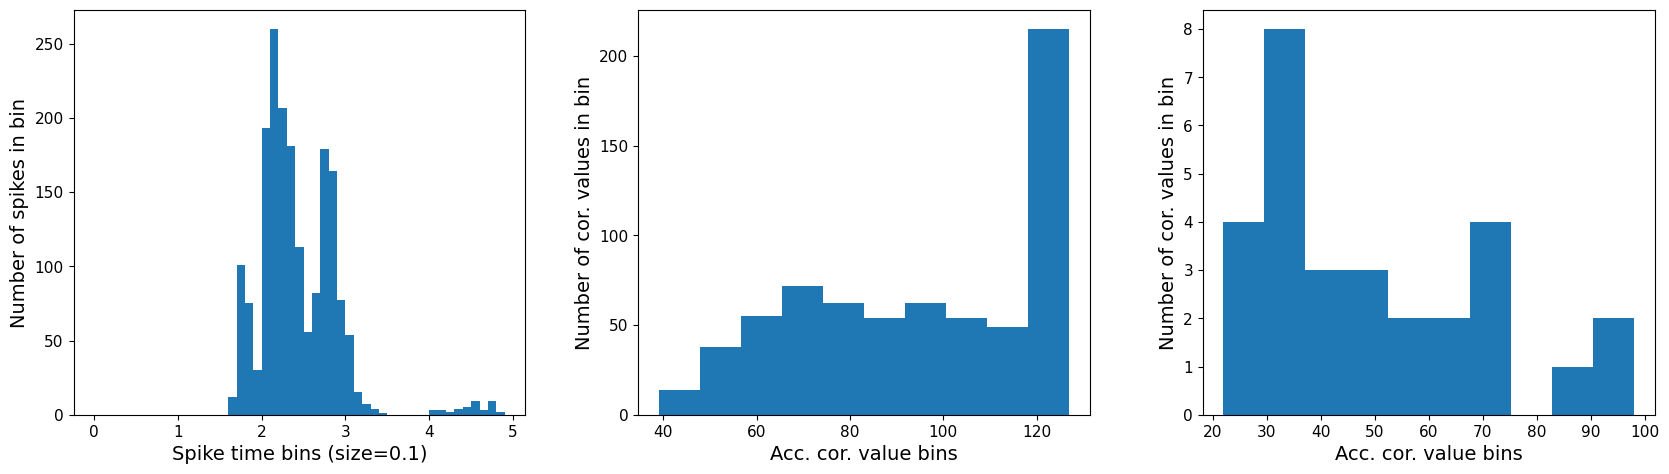

In [38]:
%matplotlib inline
plot()

In [ ]:
%matplotlib inline

counts, bins = np.histogram(spike_times_normalized, bins = np.arange(0.0, 5, 0.1))
plt.stairs(counts, bins, fill=True)
plt.show()

## Verification

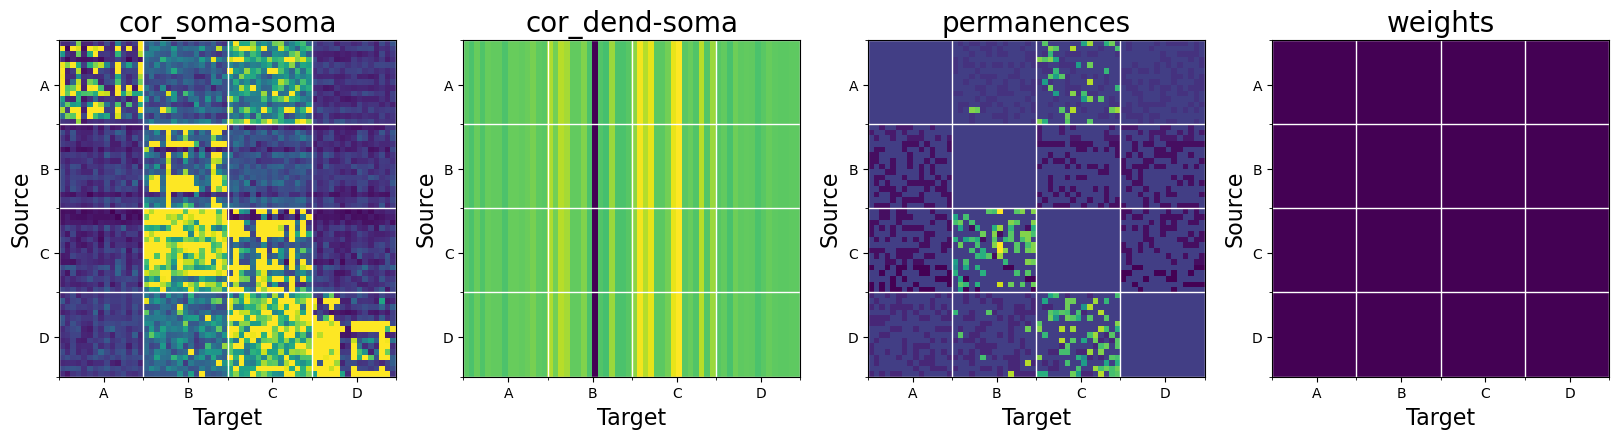

In [25]:
%matplotlib inline
shtm.plot_data_overview()

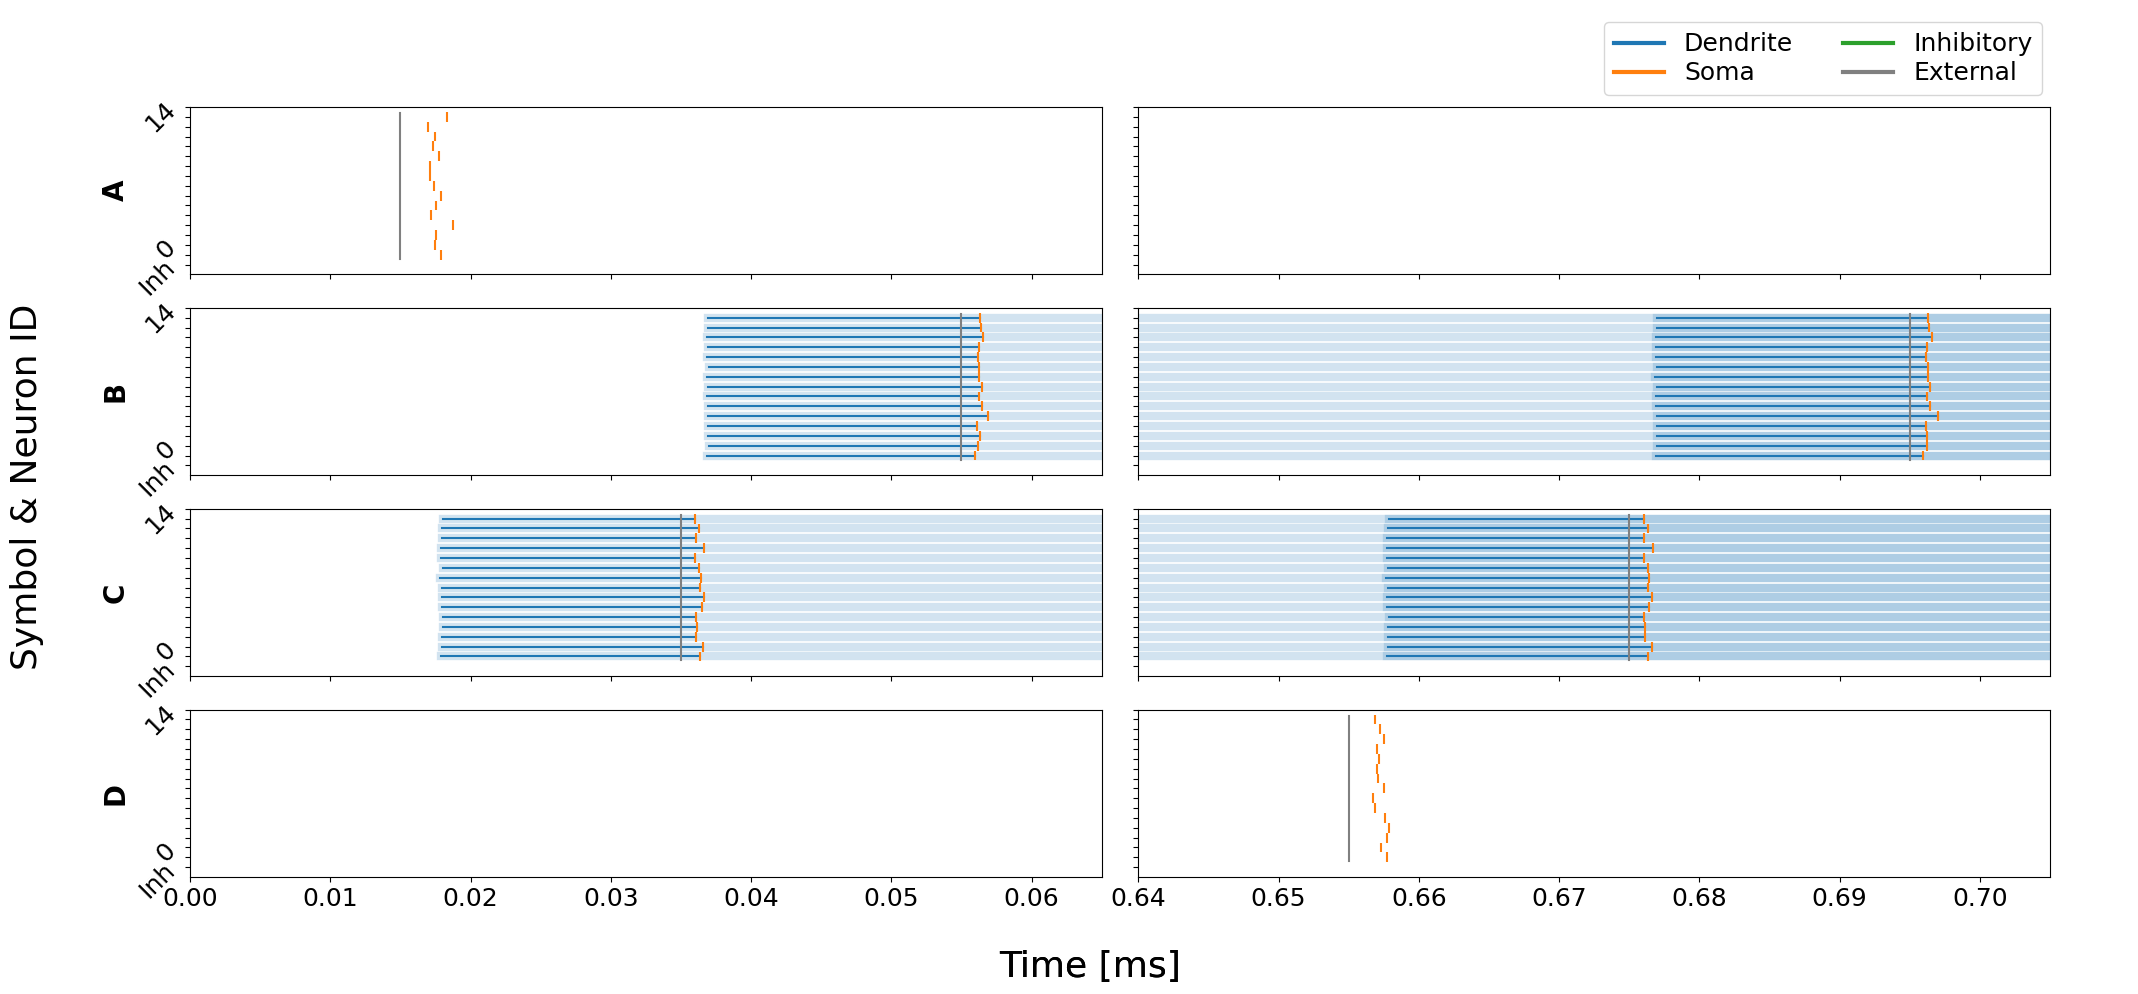

In [16]:
%matplotlib inline

run_length = shtm.p.experiment.runtime / shtm.p.encoding.num_repetitions
perf_run = np.ceil(shtm.p.plasticity.execution_start / run_length) - 1

run = 0


shtm.plot_events(neuron_types="all", size=(24, 10), 
            # window="final", 
            x_lim_lower=run*(shtm.p.experiment.runtime / shtm.p.encoding.num_repetitions), x_lim_upper=(run+1)*(shtm.p.experiment.runtime / shtm.p.encoding.num_repetitions) -shtm.p.encoding.dt_seq*0.9,
            show_grid=False,
            separate_seqs=True,
            )